# Compare Model Performance
Get the performance of the models across

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import sem
from pathlib import Path
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
runs = {
    'Parsl': Path('./prod-runs/baseline_retrain-8/'),
    'Parsl+Redis': Path('./prod-runs/parsl_retrain-8/'),
    'FuncX+Globus': Path('./prod-runs/funcx_retrain-8/'),
}

## Load in Benchmarking Dataframes
We stored the results of each dataframe

In [3]:
results = dict(
    (k, pd.read_csv(v / 'processed-results' / 'benchmark.csv')) for k, v in runs.items()
)

Get the mean from the duplicate runs

In [4]:
observed_rmsd = {}
for k, path in runs.items():
    # Get the duplicates
    with open(path / 'duplicates.json') as fp:
        dupes = json.load(fp)
    
    # Compute the mean RMSD for each run
    means = []
    for path in dupes:
        data = pd.read_csv(Path(path) / 'processed-results' / 'benchmark.csv')
        means.append(data['force_rmsd'].mean())
    observed_rmsd[k] = means

In [5]:
observed_rmsd

{'Parsl': [1.2328550095710131, 1.196038810970156],
 'Parsl+Redis': [1.6196809185506462, 1.3844473831742612],
 'FuncX+Globus': [1.2834530637749555, 1.8014592884518963, 1.4843428342096363]}

## Make a histogram
Show the distribution of errors for one of the runs

Parsl 1.2144469102705846 0.018408099300428526
Parsl+Redis 1.5020641508624537 0.1176167676881925
FuncX+Globus 1.5230850621454959 0.1507849819777486
init 1.6907795544019213


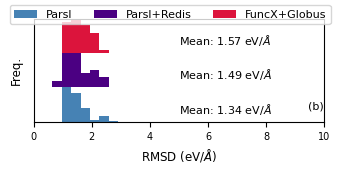

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

colors = {
    'Parsl': 'steelblue',
    'FuncX+Globus': 'crimson',
    'Parsl+Redis': 'indigo'
}

bins = np.linspace(0, 10, 32)
stack_dist = 0.75
for i, (name, result) in enumerate(results.items()):
    ax.hist(result['force_rmsd'], density=True, color=colors[name], bins=bins, label=name, bottom=i * stack_dist)
    mean = result['force_rmsd'].mean()
    ax.text(bins.mean(), i * stack_dist + stack_dist / 4, f'Mean: {mean:.2f} eV/$\\AA$', fontsize=8)
    print(name, np.mean(observed_rmsd[name]), sem(observed_rmsd[name]))
    
print('init', result['force_rmsd-init'].mean())

fig.legend(ncol=3, fontsize=8, loc='upper center')

ax.set_yticks([])
ax.set_xlim(0, bins.max())
ax.set_ylim(0, stack_dist * 3)

ax.set_ylabel('Freq.')
ax.set_xlabel('RMSD (eV/$\\AA$)')
ax.text(1, 0.1, '(b)', ha='right', va='bottom', transform=ax.transAxes, fontsize=8)

fig.tight_layout()
fig.savefig('figures/error-comparison.png', dpi=320)
fig.savefig('figures/error-comparison.pdf')

## Make a Bar Chart
So we can show the error with respect to the original

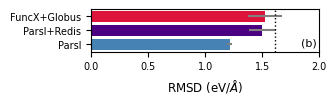

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 1.15))

stack_dist = 0.75

# Make the bar plot
name_lst = list(results.keys())
lengths = [np.mean(observed_rmsd[k]) for k in results]
errs = [sem(observed_rmsd[k]) for k in results]
colors_lst = [colors[k] for k in results]

ax.barh([0, 1, 2], lengths, color=colors_lst, xerr=errs, ecolor='gray')

ax.set_ylim(ax.get_ylim())
ax.set_yticks(range(3))
ax.set_yticklabels(results)
ax.set_xlim([0, 2])#  np.add(lengths, errs).max()])

ax.plot([result['force_rmsd-init'].mean()]*2, ax.get_ylim(), 'k:', lw=1)

ax.set_xlabel('RMSD (eV/$\\AA$)')
ax.text(0.99, 0.1, '(b)', ha='right', va='bottom', transform=ax.transAxes, fontsize=8)

fig.tight_layout()
fig.savefig('figures/error-comparison-barh.png', dpi=320)
fig.savefig('figures/error-comparison-barh.pdf')